In [58]:
import pandas as pd
import tabs
import xarray as xr
import scs
import os
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from windrose import WindroseAxes

land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

tz = 'UTC'
dstart = '2017-9-20'
dend = '2017-10-2'

key = 'Temperature'  # 'Salinity'  # or 'Temperature'

# colors
cadcp = '#FF5733'

# sizes
buoysize = 200

# plotting mins/maxes
rmaxwind = 8  # windrose wind speed max
fmaxwind = 125  # windrose wind frequency max
# stepwind = 25  # windrose step between lines for frequency
rmaxadcp = 0.5  # adcp wind rose speed max
fmaxadcp = 300  # adcp wind rose frequency max

# windrose label loc
adcplabelloc = 0.0, -0.3
windlabelloc = -0.35, 0.0

# zorders
zobuoys = 3

# decimate
dadcp = 30

# colormaps
cmapadcp = cmo.amp
cmapwind = cmo.matter

# fontsizes
fsbuoy = 18
fsstation = 18
fscolorbar = 16
fsleg = 18
fswindrose = 12

# change font to Arial
import matplotlib.pyplot as mpl
mpl.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
mpl.rcParams['font.family'] = "sans-serif"

## Read in data

### SCS/Flowthrough data

Downsample all data to 5 minutes. Combine Legs 1, 2, and 3 together into one dataframe called `ft`, and save.

In [2]:
# scs data
resample = '5T'
fname = 'data/scs.csv'
if not os.path.exists(fname):
    loc = '/Users/kthyng/Documents/data/HRR September 2017/Leg1/PS18_09_Leg1_DiMarco_SCS/Sea-Bird-Thermosalinograph-(converted-ASCII-data)_20170922-223421.Raw'
    ft = scs.read_file(loc).resample(resample, base=0, label='left').mean()

    loc = '/Users/kthyng/Documents/data/HRR September 2017/Leg2/SCS_Point Sur/PS18_09_Leg2_Whilden_SCS/Sea-Bird-Thermosalinograph-(converted-ASCII-data)_20170927-162751.Raw'
    dft = scs.read_file(loc).resample(resample, base=0, label='left').mean()
    ft = ft.append(dft)

    loc = '/Users/kthyng/Documents/data/HRR September 2017/Leg3/PS18_09_Leg3_Campbell_SCS/Sea-Bird-Thermosalinograph-(converted-ASCII-data)_20170929-172721.Raw'
    dft = scs.read_file(loc).resample(resample, base=0, label='left').mean()
    ft = ft.append(dft)
    ft.to_csv(fname)
else:
    ft = pd.read_csv(fname, parse_dates=True, index_col=0)

# still need to decimate
dc = 5

### ADCP

In [3]:
# Leg 1
loc = '/Volumes/GoogleDrive/My Drive/Documents/data_processed/adcp/ps1809l1/ps1809l1_postproc/wh300.unrotated.phasepos.amp/contour/wh300.nc'
adcp1 = xr.open_dataset(loc)

# Leg 3
loc = '/Volumes/GoogleDrive/My Drive/Documents/data_processed/adcp/ps1809l3/ps1809l3_postproc/wh300.unrotated.phasepos.phaseshift/contour/wh300.nc'
adcp3 = xr.open_dataset(loc)

# merge together after dropping conflicting unimportant variable "trajectory"
adcp = adcp1.drop('trajectory').merge(adcp3)

# dt is about 2 minutes, so 30 is about an hour of rolling mean
adcp['u'] = adcp.u.isel(depth_cell=0).rolling(time=20, center=True).mean()
adcp['v'] = adcp.v.isel(depth_cell=0).rolling(time=20, center=True).mean()


### Station data

In [4]:
names = ['Dates', 'depth [m]', 'lat', 'latmin', 'latdecmin', 'lon', 'lonmin', 'londecmin']
names2 = ['station', 'depth [m]', 'lat', 'lon', ]
basedir = '/Volumes/GoogleDrive/Shared drives/Point Sur Data: Harvey Rapid Response Cruise Oct. 2017/'
ll = pd.read_excel('%s/collection_log/HRR_collection_log.xlsx' % basedir, header=5, usecols=[0,1,2,3,4,5,6,7,8,9], 
                    parse_dates={'Dates': [1,2]}, index_col=1, skiprows=[1240,1241])
ll.columns = names
ll['lat'] = ll.lat + (ll.latmin + ll.latdecmin)/60
ll['lon'] = -(ll.lon + (ll.lonmin + ll.londecmin)/60)

ll = ll.drop(['latmin','latdecmin','lonmin','londecmin'], axis=1)

ll = ll[~ll.lat.isnull()]

ll = ll.rename({'SA*': 'SA'})
ll.to_csv('data/ll.csv')

In [5]:
ll.loc['SS'], ll.loc['S21']

(                           Dates depth [m]        lat        lon
 SS  2017-09-23 00:00:00 03:27:00     16.57  28.959750 -95.094000
 SS  2017-09-29 00:00:00 22:14:00     16.65  28.961117 -95.092717,
                             Dates depth [m]        lat        lon
 S21  2017-09-23 00:00:00 05:29:00       NaN  28.764550 -95.298167
 S21  2017-09-29 00:00:00 23:57:00     18.43  28.766267 -95.295467)

In [6]:
stations = ['GI', 'SS', 'S21', 'S16', 'S11', 'S06', 'S01', 'S07', 'S12', 'S17', 'S22']
stationsleft = ['GI', 'SS', 'S21', 'S16', 'S11', 'S06', 'S01']
stationsright = ['S07', 'S12', 'S17', 'S22']  # ['S05', 'S10', 'S15', 'S20', 'S25']

In [7]:
# some stations are doubled in the metadata but are not the same so choosing second one
ll = ll.loc[~ll.index.duplicated(keep='last')]

### Buoy data

In [8]:
# Buoys
fname = 'data/buoys.csv'
# not 8774320, 'PTAT2'
# removed: '8773701', 'mg0101', 'F', 'V', '8775792',  '8775244','8775296','8775237', 
buoynames = ['D', 'W', 'B', '42019', '42035','8773146','8772985',
             '8771972', '8773767', '8773259', '8773037',
             '8775241', '8775870']
if not os.path.exists(fname):
    buoys = pd.DataFrame()
    for buoy in buoynames:
        # read in timezone and then localize to None
        dft = tabs.read(buoy, dstart, dend, resample=('30T', 0, 'instant'), tz=tz).tz_localize(None)
        buoys = buoys.join(dft, how='outer')
    buoys.index.rename('Dates [UTC]', inplace=True)
    buoys.to_csv(fname)
else:
    buoys = pd.read_csv(fname, parse_dates=True, index_col=0)

# buoynames to plot on salinity plot (fewer than total since many stations don't have salinity data)
buoynamessalt = ['B', 'D', '42019']

In [9]:

# buoy locations
loc = 'https://raw.githubusercontent.com/kthyng/tabswebsite/master/includes/buoys.csv'
blocs = pd.read_csv(loc, index_col=0)


## Map

- [x] Salt/temp track from ship
- [x] Full ADCP track from ship
- [x] Label times periodically
- [x] Station labels
- [ ] Mean salt/temp
- [ ] wind rose

In [59]:
def setup_map(ax, left=True):
#     ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
    ax.set_extent([-98.1, -94.3, 27, 29.8], pc)
    gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
    # the following two make the labels look like lat/lon format
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'k'}  # control how the tick labels look
    gl.ylabel_style = {'size': 14, 'color': 'k'}  # control how the tick labels look
    gl.xlabels_bottom = False  # turn off labels where you don't want them
    gl.ylabels_right = False
    if not left:
        gl.ylabels_left = False
    ax.add_feature(land_10m, facecolor='0.8')
#     ax.set_facecolor('0.8')

In [60]:
def setup_params(key, leg):
    if key == 'Temperature':
        cmap = cmo.thermal
        vmin, vmax = 28.2, 29.4
        keyscs = 'Temperature'
        keytitle = 'Temperature [˚C]'
        keybuoy = 'WaterT [deg C]'
    elif key == 'Salinity':
        cmap = cmo.haline
        vmin, vmax = 22, 34
        keyscs = 'Practical salinity'
        keytitle = 'Salinity'
        keybuoy = 'Salinity'
    norm = Normalize(vmin=vmin, vmax=vmax)
    if leg == 1:
        startdate = '2017-9-22 22:00'
        enddate = '2017-9-25'
        windroseloc = [0.39, 0.595, 0.09, 0.09]
        adcproseloc = [0.15, 0.77, 0.09, 0.09]
    elif leg == 3:
        startdate = '2017-9-29 18:00'
        enddate = '2017-10-1'
        windroseloc = [0.79, 0.595, 0.09, 0.09]
        adcproseloc = [0.55, 0.77, 0.09, 0.09]
    return cmap, vmin, vmax, keyscs, keytitle, keybuoy, norm, startdate, enddate, windroseloc, adcproseloc

In [61]:
def plot_windrose(fig, loc, r, theta, rmax, fmax, blowto, label, cmap, labelloc, rlabels=True):
    ax1 = fig.add_axes(loc, projection='windrose')
    ax1.bar(theta, r, normed=False, opening=0.7,
           edgecolor='0.5', cmap=cmap, bins=np.linspace(0, rmax, 3),
           nsector=12, blowto=blowto)
    step = fmax/2
    ax1.set_yticks(np.arange(step, fmax+step, step=step))
    ax1.set_yticklabels('')
    if not rlabels:
        ax1.set_xticklabels('')
    else:
        labels = ax1.get_xticklabels()
#         print(list(labels[1::2]))
#         labels[1::2] = ''
        ax1.set_xticklabels(['E', '', 'N', '', 'W', '', 'S', ''])
    # ax1.set_yticklabels(np.arange(25, fmax, step=step, dtype=int))
    ax1.text(*labelloc, label, transform=ax1.transAxes, fontstyle='italic', verticalalignment='top', fontsize=fswindrose)

In [62]:
def plot_scs(ax, lon, lat, data, cmap, norm):
    points = np.array([lon, lat]).T.reshape(-1 ,1 ,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # https://matplotlib.org/gallery/lines_bars_and_markers/multicolored_line.html
    lc = LineCollection(segments, cmap=cmap, norm=norm, transform=pc)
    # Set the values used for colormapping
    lc.set_array(data)
    lc.set_linewidth(12)
    mappable = ax.add_collection(lc)


In [63]:
def plot_adcp(ax, lon, lat, u, v):
    Q = ax.quiver(lon, lat, u, v, transform=pc, width=0.007, scale=10, 
              headlength=1.5, headaxislength=1.5, zorder=3, color=cadcp)
    qk = ax.quiverkey(Q, 0.2, 0.9, 0.5, '0.5 $ms^{-1}$', labelpos='E', coordinates='axes', fontproperties={'size': 12})


In [64]:
# edit station label locations
station = '8775870'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.47, 0
# station = '8775296'
# blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = 0, 0
# station = '8775237'
# blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = 0, 0
station = '8775241'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.45, 0.05
station = '8773037'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.48, 0
station = '8773259'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.48, 0
station = '8773767'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.44, 0.03
station = '8771972'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.43, 0.05
station = '8772985'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.48, 0
station = '8773146'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.48, -0.02
station = '42035'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.2, -0.15
station = '42019'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.35, 0.05
station = 'B'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = 0.06, -0.1
station = 'W'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = 0.05, 0
station = 'D'
blocs.loc[station,'lonsh'], blocs.loc[station,'latsh'] = -0.05, 0.09

In [79]:
def plot_buoys(ax, names, keybuoy, bbs, cmap, vmin, vmax):
    
    # Label TABS buoys
    lons = np.asarray([blocs.loc[name,'lon'] for name in names])
    lats = np.asarray([blocs.loc[name,'lat'] for name in names])
    lonshs = np.asarray([blocs.loc[name,'lonsh'] for name in names])
    latshs = np.asarray([blocs.loc[name,'latsh'] for name in names])
    for lon, lat, lonsh, latsh, col in zip(lons, lats, lonshs, latshs, names):
        ax.text(lon + lonsh, lat + latsh, col, transform=pc, fontsize=fsbuoy, color='0.1', weight='bold')
        ax.scatter(lon, lat, transform=pc, s=buoysize, facecolor='none', edgecolor='r', zorder=zobuoys)

    # buoy data
    cols = buoys.columns[[keybuoy in col for col in buoys.columns]]  # find columns
    cols = [col for col in cols if not col == 'W: Salinity']
#     print(cols)
#     if keybuoy == 'Salinity':
#         cols.pop('W: Salinity')
    colbuoys = [col.split(':')[0] for col in cols]
    lons = [blocs.loc[name,'lon'] for name in colbuoys]
    lats = [blocs.loc[name,'lat'] for name in colbuoys]
    # subset buoy data for time range
    values = bbs.loc[:,cols].mean(axis=0)

    mappable = ax.scatter(lons, lats, c=values.values, s=buoysize, cmap=cmap,
                          transform=pc, vmin=vmin, vmax=vmax, zorder=zobuoys, edgecolor='r') #marker='*')
    
    return mappable
    

In [80]:

station = 'SS'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = -0.25, 0
print(ll.loc[station])
station = 'S21'
print(ll.loc[station])
# # ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = -0.25, 0
# ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = -0.72, 0.24, True


Dates          2017-09-29 00:00:00 22:14:00
depth [m]                             16.65
lat                                 28.9611
lon                                -95.0927
lonsh                                  -0.2
latsh                                   0.1
plotstation                            True
Name: SS, dtype: object
Dates          2017-09-29 00:00:00 23:57:00
depth [m]                             18.43
lat                                 28.7663
lon                                -95.2955
lonsh                                  -0.2
latsh                                   0.1
plotstation                            True
Name: S21, dtype: object


In [81]:
# edit station label locations
station = 'GI'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = -0.25, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = -0.2, 0.1, True  # -0.875, 0.18, True
station = 'SS'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = -0.25, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = -0.2, 0.1, True  #  -0.93, 0.05, True
station = 'S21'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = -0.25, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = -0.2, 0.1, True  #  -0.82, 0.1, True
station = 'S16'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = -0.25, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = -0.2, 0.1, True  #  -0.9, 0, True
station = 'S11'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = -0.25, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = -0.2, 0.1, True  #  -0.86, 0, True
station = 'S06'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = -0.25, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = -0.2, 0.1, True  #  -0.82, 0.16, True
station = 'S01'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = -0.25, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = -0.2, 0.1, True  #  -0.8, 0.1, True
station = 'S07'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = 0.1, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = 0.15, 0, False
station = 'S12'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = 0.1, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = 0.13, 0, False
station = 'S17'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = 0.1, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = 0.15, 0, False
station = 'S22'
# ll.loc[station,'lonshname'], ll.loc[station,'latshname'] = 0.1, 0
ll.loc[station,'lonsh'], ll.loc[station,'latsh'], ll.loc[station,'plotstation'] = 0.15, 0, False

In [82]:
def plot_station_locs_times(ax, startdate, enddate):
    for station in stations:
        lon = ll['lon'][station]
        lat = ll['lat'][station]
        plotstation = ll['plotstation'][station]
        # label times and station names on map
        time = ((ft[startdate:enddate].lat - lat)**2 + (ft[startdate:enddate].lon - lon)**2).idxmin()
        timelabel = ''#time.round('H').strftime('%b %d %H')
        if plotstation:
            ax.plot(lon, lat, 'o', transform=pc, color='k', markersize=10)
            timelabel += station
#             timelabel += ': ' + station
        else:
            ax.plot(lon, lat, '.', transform=pc, color='k', markersize=10)
        lonsh, latsh = ll.loc[station,['lonsh', 'latsh']]
        ax.text(lon + lonsh, lat + latsh,  timelabel, transform=pc, fontsize=fsstation, color='k', weight='bold')


In [83]:
def add_colorbar(mappable, axes, keytitle):
    # colorbar
    cb = fig.colorbar(mappable, ax=axes, orientation='horizontal', pad=0.02, shrink=0.5, aspect=40, extend='both')
    cb.set_label(keytitle, fontsize=fscolorbar)
    cb.ax.tick_params(labelsize=fscolorbar) 

In [84]:
def plot_all(key, leg, ax, left=True, windrose=True, buoylist=buoynames):
    cmap, vmin, vmax, keyscs, keytitle, keybuoy, norm, startdate, enddate, windroseloc, adcproseloc = setup_params(key, leg)

    setup_map(ax, left=left)

    # SCS
    plot_scs(ax, ft['lon'][startdate:enddate:dc], ft['lat'][startdate:enddate:dc], ft[keyscs][::dc], cmap, norm)

    if windrose:
        # ADCP
        # only pull out ADCP for along coast, between WF and S01. Use scs data to find time.
        station = 'WF'
        lon = ll['lon'][station]
        lat = ll['lat'][station]
        startdateADCP = ((ft[startdate:enddate].lat - lat)**2 + (ft[startdate:enddate].lon - lon)**2).idxmin()
        station = 'S01'
        lon = ll['lon'][station]
        lat = ll['lat'][station]
        enddateADCP = ((ft[startdate:enddate].lat - lat)**2 + (ft[startdate:enddate].lon - lon)**2).idxmin()

        lon = adcp.lon.sel(time=slice(startdateADCP,enddateADCP)).data
        lat = adcp.lat.sel(time=slice(startdateADCP,enddateADCP)).data
        u = adcp.u.sel(time=slice(startdateADCP,enddateADCP)).data
        v = adcp.v.sel(time=slice(startdateADCP,enddateADCP)).data
    #     plot_adcp(ax, lon, lat, u, v)


        # ADCP as wind rose
        r = np.sqrt(u**2 + v**2)
        theta = np.rad2deg(np.arctan2(v, u))  # counter clockwise, mathwise
        theta = 90 - theta
        inan = ~np.isnan(r)
        plot_windrose(fig, adcproseloc, r[inan], theta[inan], rmax=rmaxadcp, fmax=fmaxadcp, blowto=False, 
                      label='shipboard ADCP\n alongshore', cmap=cmapadcp, labelloc=adcplabelloc)
#         print(r[inan], theta[inan])

        # Wind as wind rose
        buoy = '42019'
        r = buoys[startdate:enddate][buoy + ': Speed [m/s] (air)'].values
        theta = buoys[startdate:enddate][buoy + ': Dir from [deg T] (air)'].values
        inan = ~np.isnan(r)
        plot_windrose(fig, windroseloc, r[inan], theta[inan], rmax=rmaxwind, fmax=fmaxwind, blowto=True, 
                      label=buoy + ' wind', cmap=cmapwind, labelloc=windlabelloc, rlabels=True)
#         print(r[inan], theta[inan])

    # Buoys
    mappable = plot_buoys(ax, buoylist, keybuoy, buoys[startdate:enddate], cmap, vmin, vmax)


    # Label stations
    plot_station_locs_times(ax, startdate, enddate)
    
    return mappable, keytitle


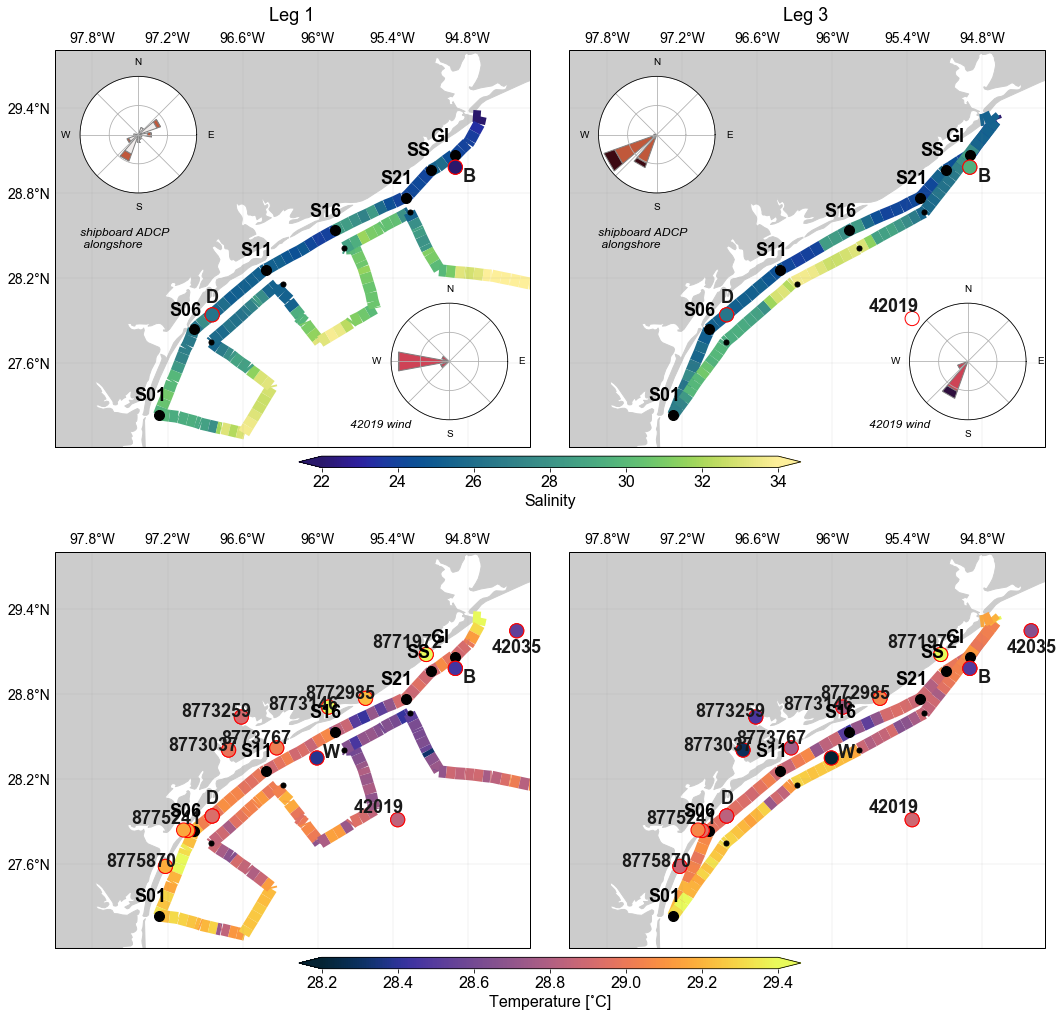

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(18, 18), subplot_kw={'projection': merc})
fig.subplots_adjust(wspace=0.05, hspace=0.05)

axes[0,0].text(0.45, 1.075, 'Leg 1', fontsize=fsleg, transform=axes[0,0].transAxes)
_, _ = plot_all(key='Salinity', leg=1, ax=axes[0,0], windrose=False, buoylist=buoynamessalt[:-1])
mappable, keytitle = plot_all(key='Salinity', leg=3, ax=axes[0,1], left=False, windrose=False, buoylist=buoynamessalt)
    
# colorbar
add_colorbar(mappable, axes[0,:], keytitle)


axes[0,1].text(0.45, 1.075, 'Leg 3', fontsize=fsleg, transform=axes[0,1].transAxes)
_, _ = plot_all(key='Temperature', leg=1, ax=axes[1,0], windrose=True, buoylist=buoynames)
mappable, keytitle = plot_all(key='Temperature', leg=3, ax=axes[1,1], left=False, windrose=True, buoylist=buoynames)
    
# colorbar
add_colorbar(mappable, axes[1,:], keytitle)

fig.savefig('figures/summary.png', bbox_inches='tight', dpi=300)